In [64]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


learning_rate = 0.001
batch_size = 400
Nsubc = 64
modulation_level = 4

X = torch.randn(batch_size, Nsubc*modulation_level, dtype=torch.float32)
corruption = torch.randn(batch_size, Nsubc, dtype=torch.complex64)
print(X)
print(corruption)

tensor([[-0.4801, -1.4650, -0.7513,  ...,  1.7610, -1.7324, -0.0349],
        [-0.3581, -1.6418, -0.1418,  ...,  2.3039, -1.4007, -2.0302],
        [-0.9132,  0.8190, -0.3675,  ...,  0.4129, -1.5468,  0.7728],
        ...,
        [ 1.9027, -0.9931,  0.0473,  ..., -2.9115, -0.1718,  1.7720],
        [-0.4343, -1.8041, -0.4225,  ...,  1.9473, -0.9307,  0.0301],
        [ 0.2563,  0.3702, -0.2062,  ..., -0.2676, -0.1522, -0.4605]])
tensor([[-0.1228+0.4085j,  0.1125+0.9784j, -1.4140+0.1452j,  ...,
          0.2951+0.7546j, -0.9777-1.2503j,  0.0804-0.6318j],
        [ 0.2572+0.0372j,  0.5159+0.2283j, -0.5204-0.2325j,  ...,
          0.8157+0.2825j, -0.9228+0.7593j, -1.2929+0.3694j],
        [-0.0956-0.1483j, -0.3194+0.1104j,  0.3194+1.0267j,  ...,
         -0.8582-0.8805j, -0.1373-0.1031j, -0.0505-0.8873j],
        ...,
        [-0.4824-1.5997j, -0.2623+0.5419j, -0.7708-1.7958j,  ...,
          0.3140-0.5935j,  0.3345+0.5343j, -0.5861+0.2453j],
        [ 0.1096+0.0611j, -0.6559+0.0491j, -0

In [65]:
#PRnet
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(Nsubc*modulation_level,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 2*Nsubc),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2*Nsubc,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048,Nsubc*modulation_level),
        )
    def forward(self, X):
        raw_symbol = self.encoder(X)
        even_number = torch.arange(0, 2*Nsubc, 2)
        odd_number = torch.arange(1, 2*Nsubc, 2)
        X_real = raw_symbol[:, even_number]
        X_imag = raw_symbol[:, odd_number]
        encoded_symbol_complex = torch.complex(X_real, X_imag)
        encoded_symbol_ifft = torch.fft.ifft(encoded_symbol_complex)
        encoded_symbol_normalizing = torch.sqrt(torch.mean(torch.square(torch.abs(encoded_symbol_ifft))))
        encoded_symbol_original_r = torch.real(encoded_symbol_ifft)/encoded_symbol_normalizing
        encoded_symbol_original_i = torch.imag(encoded_symbol_ifft)/encoded_symbol_normalizing
        encoded_symbol_original = torch.complex(encoded_symbol_original_r, encoded_symbol_original_i)
        peak_power_batch = torch.max(torch.square(torch.abs(encoded_symbol_original)))
        avr_power_batch = torch.mean(torch.square(torch.abs(encoded_symbol_original)))
        peak_power_symbol = torch.max(torch.abs(encoded_symbol_original),axis = 1)
        encoded_symbol = encoded_symbol_original + corruption
        received_symbol_complex = torch.fft.fft(encoded_symbol)
        received_symbol_r = torch.real(received_symbol_complex)
        received_symbol_i = torch.imag(received_symbol_complex)
        received_symbol = torch.concat([received_symbol_r,received_symbol_i], axis = 1)
        hypothesis = self.decoder(received_symbol)
        return hypothesis

In [68]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

losses = []
num_epochs = 50
for epoch in range(num_epochs):
    reconstruct_X = model(X)
    loss = criterion(reconstruct_X, X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss)
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')



Epoch:1, Loss:1.1747
Epoch:2, Loss:1.0431
Epoch:3, Loss:0.5957
Epoch:4, Loss:0.4678
Epoch:5, Loss:0.4227
Epoch:6, Loss:0.3246
Epoch:7, Loss:0.2392
Epoch:8, Loss:0.2087
Epoch:9, Loss:0.2001
Epoch:10, Loss:0.1726
Epoch:11, Loss:0.1322
Epoch:12, Loss:0.1046
Epoch:13, Loss:0.0970
Epoch:14, Loss:0.0938
Epoch:15, Loss:0.0800
Epoch:16, Loss:0.0597
Epoch:17, Loss:0.0466
Epoch:18, Loss:0.0448
Epoch:19, Loss:0.0440
Epoch:20, Loss:0.0360
Epoch:21, Loss:0.0251
Epoch:22, Loss:0.0197
Epoch:23, Loss:0.0199
Epoch:24, Loss:0.0194
Epoch:25, Loss:0.0149
Epoch:26, Loss:0.0097
Epoch:27, Loss:0.0080
Epoch:28, Loss:0.0089
Epoch:29, Loss:0.0085
Epoch:30, Loss:0.0058
Epoch:31, Loss:0.0037
Epoch:32, Loss:0.0039
Epoch:33, Loss:0.0047
Epoch:34, Loss:0.0039
Epoch:35, Loss:0.0025
Epoch:36, Loss:0.0022
Epoch:37, Loss:0.0027
Epoch:38, Loss:0.0028
Epoch:39, Loss:0.0022
Epoch:40, Loss:0.0017
Epoch:41, Loss:0.0019
Epoch:42, Loss:0.0020
Epoch:43, Loss:0.0018
Epoch:44, Loss:0.0015
Epoch:45, Loss:0.0014
Epoch:46, Loss:0.00

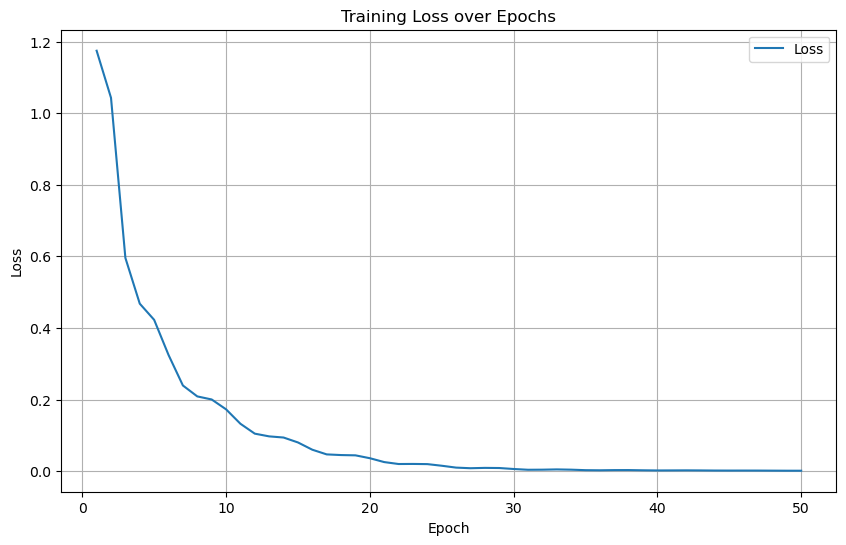

In [72]:

loss_values = [loss.item() for loss in losses]

# Plotting the losses over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, label='Loss')
plt.semilogy
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()
